# Students Do: Predicting Gold Closing Prices

In this activity, you will gain hands-on experience by building an RNN LSTM for predicting gold closing prices using time-series data.

In [3]:
# Initial imports
import numpy as np
import pandas as pd
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

%matplotlib inline

## Instructions

### Initial Setup

To ensure models' reproducibility, set the random seed for `numpy` and `tensorflow` libraries.

In [26]:
# Set current amount of shares data
shares_data = {
    "shares": [100]
}

# Set the tickers
#tickers = ["MSFT", "AAPL"]
tickers = ["UBER"]

# Create the shares DataFrame with `tickers` as index
df_shares = pd.DataFrame(shares_data, index=tickers)

# Display shares data
df_shares

,shares
UBER,100


In [27]:
## Load and Verify Environment Variables
# Load .env environment variables
load_dotenv()

True

In [28]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [29]:
# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [11]:
## Create the Alpaca API Object

In [30]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [33]:
# Format current date as ISO format
today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()
start = pd.Timestamp("2020-07-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-01-30", tz="America/New_York").isoformat()

In [34]:
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"

In [35]:
# Get current price data for USAU and UBER
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end
).df

# Display sample data
df_portfolio

UBER                                    
                              open     high     low    close    volume
time                                                                  
2020-09-08 00:00:00-04:00  32.3600  35.1000  32.160  34.3100  63952879
2020-09-09 00:00:00-04:00  34.1100  35.5000  34.110  35.0100  42961886
2020-09-10 00:00:00-04:00  35.9699  36.7800  35.850  35.9800  55807178
2020-09-11 00:00:00-04:00  36.3000  37.1450  36.254  36.9768  49916987
2020-09-14 00:00:00-04:00  37.1000  38.0000  37.080  37.9400  49062438
...                            ...      ...     ...      ...       ...
2021-01-25 00:00:00-05:00  54.5000  54.5200  49.650  54.3000  40247115
2021-01-26 00:00:00-05:00  54.6200  55.5200  51.530  51.9400  20726289
2021-01-27 00:00:00-05:00  49.9700  50.8600  47.150  48.0800  31899724
2021-01-28 00:00:00-05:00  50.1200  52.5200  49.880  51.5900  26767689
2021-01-29 00:00:00-05:00  50.6300  51.4899  50.265  50.9500  12715458

[100 rows x 5 columns]

In [36]:
## UBER CLOSE
uber_close = df_portfolio["UBER"]["close"]
uber_close

time
2020-09-08 00:00:00-04:00    34.3100
2020-09-09 00:00:00-04:00    35.0100
2020-09-10 00:00:00-04:00    35.9800
2020-09-11 00:00:00-04:00    36.9768
2020-09-14 00:00:00-04:00    37.9400
                              ...   
2021-01-25 00:00:00-05:00    54.3000
2021-01-26 00:00:00-05:00    51.9400
2021-01-27 00:00:00-05:00    48.0800
2021-01-28 00:00:00-05:00    51.5900
2021-01-29 00:00:00-05:00    50.9500
Name: close, Length: 100, dtype: float64

In [37]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

#### Create the Features `X` and Target `y` Data

Use the `window_data()` function bellow, to create the features set `X` and the target vector `y`. Define a window size of `30` days and use the column of the closing gold price as feature and target column; this will allow your model to predict gold prices in CAD.

In [38]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [39]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(uber_close, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

IndexingError: Too many indexers

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [6]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [7]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [8]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.00728531]
  [0.00781245]
  [0.00702174]
  [0.00797464]
  [0.00696092]
  [0.0064946 ]
  [0.00366969]
  [0.00296008]
  [0.00389947]
  [0.00446039]
  [0.00520379]
  [0.00647433]
  [0.00653515]
  [0.00696092]
  [0.00808953]
  [0.00653515]
  [0.00587961]
  [0.00362914]
  [0.00290601]
  [0.00588637]
  [0.00533896]
  [0.00742723]
  [0.00641351]
  [0.00651488]
  [0.00526462]
  [0.00451446]
  [0.00187877]
  [0.00171658]
  [0.00447391]
  [0.00406166]]

 [[0.00781245]
  [0.00702174]
  [0.00797464]
  [0.00696092]
  [0.0064946 ]
  [0.00366969]
  [0.00296008]
  [0.00389947]
  [0.00446039]
  [0.00520379]
  [0.00647433]
  [0.00653515]
  [0.00696092]
  [0.00808953]
  [0.00653515]
  [0.00587961]
  [0.00362914]
  [0.00290601]
  [0.00588637]
  [0.00533896]
  [0.00742723]
  [0.00641351]
  [0.00651488]
  [0.00526462]
  [0.00451446]
  [0.00187877]
  [0.00171658]
  [0.00447391]
  [0.00406166]
  [0.00427792]]

 [[0.00702174]
  [0.00797464]
  [0.00696092]
  [0.0064946 ]
  [0.00366969

---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [9]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure

Design the structure of your RNN LSTM as follows:

* Number of units per layer: `30` (same as the window size)

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to your model, remember to add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [10]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [11]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
39/39 [==============================] - 4s 96ms/step - loss: 0.0053
Epoch 2/10
39/39 [==============================] - 3s 81ms/step - loss: 0.0188
Epoch 3/10
39/39 [==============================] - 3s 72ms/step - loss: 0.0070
Epoch 4/10
39/39 [==============================] - 3s 73ms/step - loss: 0.0054
Epoch 5/10
39/39 [==============================] - 3s 70ms/step - loss: 0.0058
Epoch 6/10
39/39 [==============================] - 2s 62ms/step - loss: 0.0071
Epoch 7/10
39/39 [==============================] - 2s 59ms/step - loss: 0.0102
Epoch 8/10
39/39 [==============================] - 2s 48ms/step - loss: 0.0225
Epoch 9/10
39/39 [==============================] - 2s 50ms/step - loss: 0.0180
Epoch 10/10
39/39 [==============================] - 2s 56ms/step - loss: 0.0128


---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [14]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.018898528069257736

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [15]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

Since you scaled the original values using the `MinMaxScaler`, you need to recover the original gold prices to better understand of the predictions. Use the `inverse_transform()` method of the scaler to decode the scaled testing and predicted values to their original scale.

In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

#### Plotting Predicted Vs. Real Prices

Create a Pandas DataFrame with two columns as follows to plot the predicted vs. the actual gold prices.

* Column 1: Actual prices (testing data)

* Column 2: Predicted prices

Your DataFrame should look like the sample below:

![Sample actual vs. predicted gold prices](../Images/sample-gold-prices-predictions-df-v2.png)

In [17]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = gold_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2014-10-30,1479.92,1248.177490
2014-10-31,1460.00,1248.690918
2014-11-03,1470.24,1248.013184
2014-11-04,1472.27,1245.294556
2014-11-05,1443.81,1240.719727


Use the `plot()` method from the DataFrame to create a line chart to contrast the actual vs. the predicted gold prices.

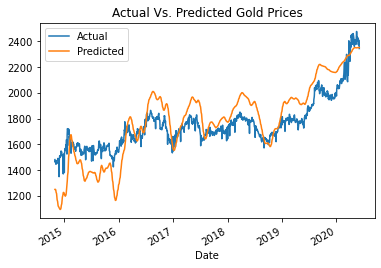

In [18]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted Gold Prices")